In [295]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [296]:
#install GSDMM/vaderSentiment
!pip install git+https://github.com/rwalk/gsdmm.git
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-copsaeox
  Running command git clone -q https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-copsaeox
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [297]:
import pandas as pd
import numpy as np
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from gsdmm import MovieGroupProcess
import re

#filename = "AMAZON_FASHION_5.json"
filename = "/content/drive/MyDrive/Github/CSCI-5525-final-project/AMAZON_FASHION_5.json"


df = pd.read_json(path_or_buf=filename, lines=True)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [298]:
#df['asin'].value_counts()

In [299]:
#list(df[df['asin'] == 'B009MA34NY']['reviewText'])

In [300]:
import json

#filename = "/content/drive/MyDrive/Github/CSCI-5525-final-project/AMAZON_FASHION_5.json"
def load_reviews(filename):
  with open(filename) as f:
      reviews_json = f.readlines()

  reviews = []
  for review_json in reviews_json:
      review = json.loads(review_json)
      if "overall" in review and "reviewText" in review:
          reviews.append(
              {
                  "rating": review["overall"],
                  "title": review["summary"],
                  "text": review["reviewText"],
              }
          )
  return reviews

reviews = load_reviews(filename)
#df = pd.DataFrame.from_dict(reviews)

In [301]:
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# NMF and LDA
Adapted from [here](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html), minimal original work.

The topics are extracting nothing of note.

Further steps:

- find a product with enough reviews to be worth analyzing alone (might have to request the full dataset)
- mess around with heuristics for vectorizing terms (reducing `max_df` probably but didn't manage to get different results)
- eliminate boring reviews?

In [302]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation
from sklearn.decomposition import LatentDirichletAllocation

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

product_id = 'B009MA34NY'
if product_id:
    data_samples = list(filter(lambda x: isinstance(x, str), df[df['asin'] == product_id]['reviewText']))
else:
    data_samples = list(map(lambda x: x['text'], reviews))[:n_samples]


for s in data_samples:

    if not isinstance(s,str):
        print(s)

In [303]:
#preprocessing
def lowercasing(data_samples):
  for idx, sample in enumerate(data_samples):
    data_samples[idx] = sample.lower()
  return data_samples

def punctuation_removal(data_samples):
#non-exhaustive; not sure if we want to treat punctuation as significant
#doesn't remove punctuation from inside words
  for i, sample in enumerate(data_samples):
    _sample = sample.split()
    for j, word in enumerate(_sample):
      _sample[j] = word.strip(" .!?@#&():;,'\/\\")
    sample = " ".join(_sample)
    data_samples[i] = sample
  return data_samples

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1]
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize(data_samples):
  wnl = WordNetLemmatizer()
  for i, sample in enumerate(data_samples):
      _sample = sample.split()
      for j, word in enumerate(_sample):
        tag = get_wordnet_pos(word)
        if (tag == 'r') or (tag == 'a') or (tag == 'v'):
          _sample[j] = ""
          idk = i
        else:
          _sample[j] = wnl.lemmatize(word,tag)
      data_samples[i] = ' '.join(_sample)
      data_samples[i] = re.sub(' +', ' ', data_samples[i])

  return data_samples

data_samples = lowercasing(data_samples)
data_samples = punctuation_removal(data_samples)
data_samples = lemmatize(data_samples)

In [304]:
#LDA bigrams
#Original code by Nicha Ruchirawat
#https://nicharuc.github.io/topic_modeling/

stop_word_list = set(nltk.corpus.stopwords.words('english'))
ds = pd.DataFrame(data_samples)
ds.columns = ['review']

bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([r.split() for r in ds.review])
# Filter only those that occur at least x times
finder.apply_freq_filter(10)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [305]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([r.split() for r in ds.review])
# Filter only those that occur at least x times
finder.apply_freq_filter(2)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [306]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [307]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [308]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    return True

In [309]:
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    return True 

In [310]:
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram: bigram_filter(bigram['bigram']) and bigram.pmi > 3, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: trigram_filter(trigram['trigram']) and trigram.pmi > 17, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [311]:
# examples of bigrams
bigrams[:10]

['light weight', 'arch support', 'feel like', 'fit perfect']

In [312]:
# examples of trigrams
trigrams[:10]

['supreme tr 3',
 "women's flex supreme",
 'flex supreme tr',
 'cardio dance class']

In [313]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [314]:
reviews_w_ngrams = ds.copy()

In [315]:
reviews_w_ngrams.review = reviews_w_ngrams.review.map(lambda x: replace_ngram(x))

In [329]:
_data_samples = reviews_w_ngrams.values.tolist()
data_samples = [item for sublist in _data_samples for item in sublist]

In [317]:
#len(data_samples)

In [318]:
#print(len(tfidf_vectorizer.stop_words_))
#tfidf_vectorizer.stop_words_

In [319]:
#tfidf_vectorizer.get_stop_words()

In [330]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.01, min_df=2, max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(data_samples)
tf_vectorizer.stop_words_

Extracting tf features for LDA...


{'000',
 '10',
 '100',
 '12',
 '15',
 '169lbs',
 '1st',
 '20',
 '24',
 '25',
 '30',
 '3rd',
 '3x',
 '40',
 '50',
 'abd',
 'abit',
 'absorption',
 'accommodate',
 'achilles',
 'activity',
 'adjust',
 'adjustment',
 'advice',
 'aerobic',
 'afford',
 'afraid',
 'aide',
 'airport',
 'airy',
 'allows',
 'amazing',
 'amazon',
 'ankle',
 'arch',
 'arch_support',
 'area',
 'arose',
 'artculo',
 'asics',
 'attention',
 'awesome',
 'az',
 'bag',
 'bailing',
 'band',
 'bandage',
 'barefeet',
 'barefoot',
 'base',
 'beach',
 'beat',
 'bed',
 'bend',
 'bit',
 'blister',
 'blood',
 'bluff',
 'boot',
 'bootcamps',
 'bother',
 'bought',
 'box',
 'boxier',
 'brand',
 'breath',
 'breathe',
 'breathes',
 'bright',
 'broader',
 'btw',
 'build',
 'bulk',
 'bunion',
 'business',
 'cable',
 'calf',
 'cam',
 'card',
 'cardio',
 'care',
 'careful',
 'carpet',
 'change',
 'cheap',
 'check',
 'christmas',
 'circulation',
 'cl',
 'class',
 'cleaning',
 'client',
 'clorox',
 'closer',
 'closet',
 'clothes',
 'coac

Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


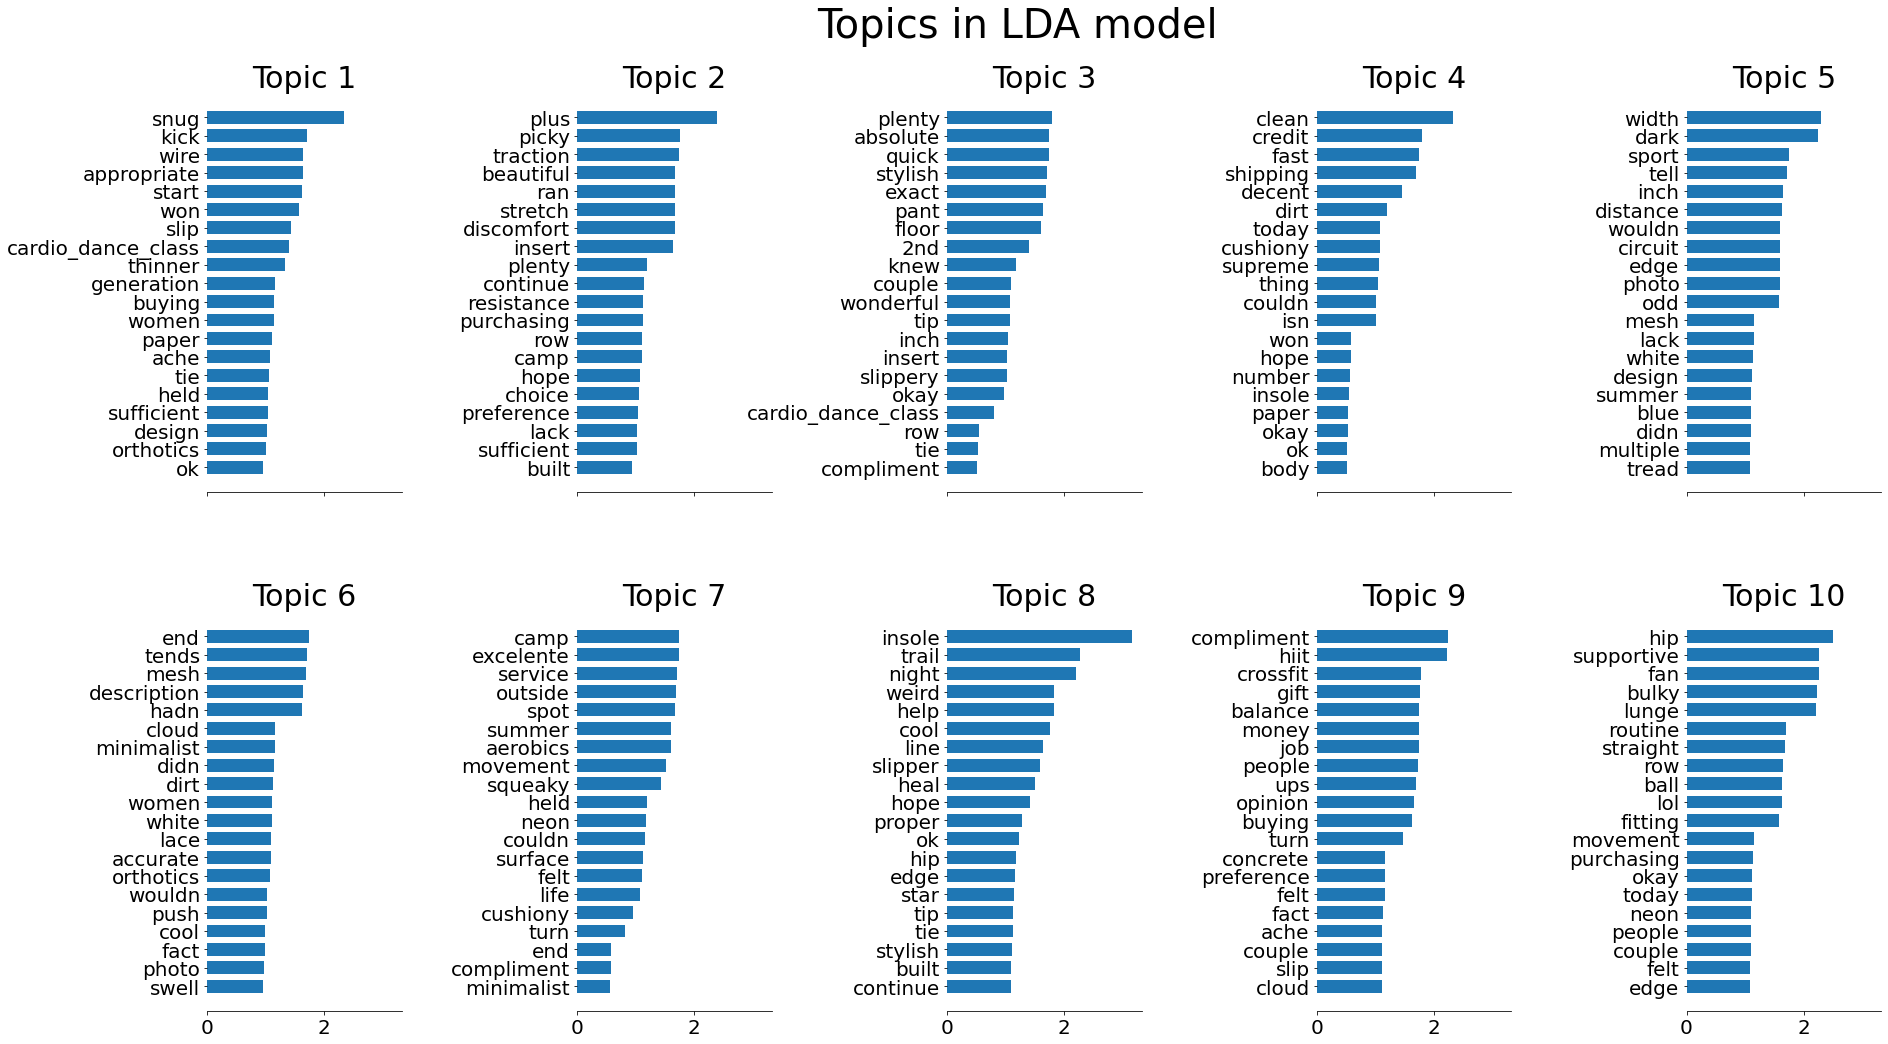

In [326]:
print(
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [ ]:
for i, sample in enumerate(data_samples):
    if len(sample) > 300 and len(sample) < 700:
        print(i,":", sample)

In [ ]:
lda.transform(tf_vectorizer.transform([data_samples[84]]))

In [ ]:
data_samples[84]

In [ ]:
from nltk import sent_tokenize
from nltk.tokenize import TweetTokenizer

raw_reviews = list(filter(lambda x: isinstance(x, str), df[df['asin'] == product_id]['reviewText']))

#raw_reviews[337] were the sentences you were using prior for sentiment analysis
def get_sents(raw_reviews):
  raw_sentences = []
  for review in raw_reviews:
    raw_sentences.append(sent_tokenize(review))
  raw_sentences = sum(raw_sentences, [])

  processed_sentences = raw_sentences[:]
  processed_sentences = lowercasing(processed_sentences)
  processed_sentences = punctuation_removal(processed_sentences)
  processed_sentences = lemmatize(processed_sentences)
  return raw_sentences, processed_sentences

raw_sentences, processed_sentences = get_sents(raw_reviews)

In [ ]:
#GSDMM
raw_reviews = list(map(lambda x: x['text'], reviews))[:n_samples]
raw_sentences, processed_sentences = get_sents(raw_reviews)

In [ ]:
#GSDMM
tknzr = TweetTokenizer()
def get_words(sentences):
  words = []
  for sentence in sentences:
    words.append(tknzr.tokenize(sentence))
  return words

def remove_stopwords(words):
  #Just using nltk stopwords for now
  stops = set(nltk.corpus.stopwords.words('english'))
  _words = []
  for word in words:
    if word not in stops:
      _words.append(word)
  return _words

docs = get_words(processed_sentences)
for i, words in enumerate(docs):
  docs[i] = remove_stopwords(words)
  docs[i] = list(set(docs[i]))

vocab = set(x for word in words for x in word)

mgp = MovieGroupProcess(K=10, alpha=.01, beta=.01, n_iters=30)
# tutorials I saw used bigrams/trigrams for tokens in docs; might be an option for us
model = mgp.fit(docs, len(vocab))

In [ ]:
#credit to Catherine
#https://www.kaggle.com/code/ptfrwrd/topic-modeling-guide-gsdm-lda-lsi/notebook

def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))

doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 5 words in term frequency for each cluster 
top_words(mgp.cluster_word_distribution, top_index, 10)

In [ ]:
feature_names = tf_vectorizer.get_feature_names_out()
topic_words = []
for topic in lda.components_:
    top_features_ind = topic.argsort()[: -10- 1 : -1]
    topic_words.append([feature_names[i] for i in top_features_ind])

In [ ]:
feature_names = tf_vectorizer.get_feature_names_out()
topic_words = []
for topic in lda.components_:
    top_features_ind = topic.argsort()[: -10- 1 : -1]
    topic_words.append([feature_names[i] for i in top_features_ind])
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# TODO: for now compound (a composite score) will suffice. Neutrality (neu) might suggest highly informational content.
#Had to change some of the sentence processing code so the sentences were't limited
#in that code block. I limited the sentences here for endless print statment reasons
for raw, processed in zip(raw_sentences[:20], processed_sentences[:20]):
    vs = analyzer.polarity_scores(raw)
    probs = lda.transform(tf_vectorizer.transform([processed]))[0]
    topic = probs.argmax()
    if probs[topic] < 0.2:
        print("{} \n\t overall: {:.2f} neutral: {:.2f}, No Topic\n".format(raw, vs['compound'], vs['neu']))
    else:
        print("{} \n\t overall: {:.2f} neutral: {:.2f}, Topic {}: {}\n".format(raw, vs['compound'], vs['neu'], topic+1, ", ".join(topic_words[topic])))

In [ ]:
lda.transform(tf_vectorizer.transform(["easy gift life"])).argmax()
topic_words[6]